# Описание проекта

Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. 

Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
-  лог сервера с данными о посещениях сайта Яндекс.Афиши,
-  выгрузка всех заказов за этот период,
-  статистика рекламных расходов.


Вам предстоит изучить:
-  как клиенты пользуются сервисом,
-  когда делают первые покупки на сайте,
-  сколько денег приносит компании каждый клиент,
-  когда расходы на привлечение клиента окупаются.


Выручка измеряется в условных единицах — у.е.

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Загрузка данных и подготовка к анализу

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

### Изучение данных из файлов

In [3]:
visits.info()
visits.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


Пропуски в датафрейме visits отсутствуют, необходмо переименовать столбцы и привести данные из столбцов Start Ts и End Ts к формату даты.

In [4]:
orders.info()
orders.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


Пропуски в датафрейме orders отсутствуют, необходмо переименовать столбцы и привести данные из столбца Buy Ts к формату даты.

In [5]:
costs.info()
costs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


Пропуски отсутствуют, переименование столбцов не требуется, только изменения типов данных на дату в столбце dt.

### Изменение типов данных, переименование столбцов, добавление данных в visits.

Переименую столбцы в таблицах visits и orders

In [6]:
visits.columns = visits.columns.str.lower()
visits = visits.rename({'end ts' : 'end_ts', 'source id' : 'source_id', 'start ts' : 'start_ts'}, axis='columns')
orders.columns = orders.columns.str.lower()
orders = orders.rename({'buy ts' : 'buy_ts'}, axis='columns')

Изменю типы данных во всех трех датафреймах

In [7]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] =pd.to_datetime(visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

Для дальнейшего исследования будут необходимы данные о дате, дне, номере недели и месяце в датафреймах visits и orders, добавляю их к таблицам

In [8]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].astype('datetime64[D]')
visits['day'] = visits['start_ts'].dt.day
orders['year'] = orders['buy_ts'].dt.year
orders['month'] = orders['buy_ts'].dt.month
orders['week'] = orders['buy_ts'].astype('datetime64[W]')
orders['day'] = orders['buy_ts'].astype('datetime64[D]')

In [9]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,1
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27,27


In [10]:
print("Дублирующихся строк в таблице visits:", visits.duplicated().sum())
print("Дублирующихся строк в таблице orders:", orders.duplicated().sum())
print("Дублирующихся строк в таблице costs:", costs.duplicated().sum())

Дублирующихся строк в таблице visits: 0
Дублирующихся строк в таблице orders: 0
Дублирующихся строк в таблице costs: 0


Дубли в датафреймах отсутствуют.

## Расчёт метрик и построение графиков

### DAU, MAU, WAU

Рассчитаю DAU и построю график изменения данных во времени:

В среднем в день сервис используют 907 уникальных пользователей


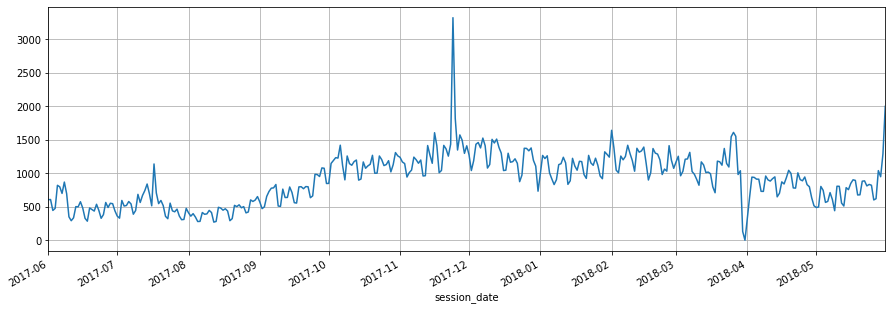

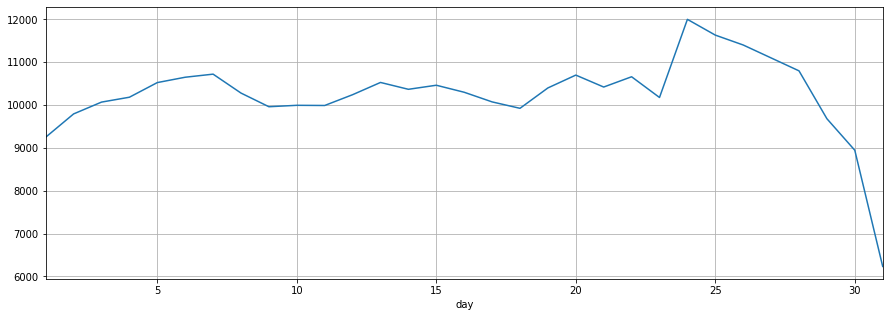

In [11]:
dau_total = visits.groupby(['session_date']).agg({'uid': 'nunique'}).mean()
print('В среднем в день сервис используют {} уникальных пользователей'.format(int(dau_total)))
visits.groupby(['session_date']).agg({'uid': 'nunique'}).plot(grid=True, figsize=(15, 5)).get_legend().remove()
visits.groupby(['day']).agg({'uid': 'nunique'}).plot(grid=True, figsize=(15, 5)).get_legend().remove()

**Выводы:** На графике по количеству пользователей на дату виден рост пользователей к концу 2017 года, к середине 2018 года происходит спад.

На втором графике, по каждому числу месяца, можно увидеть всплеск количества пользователей ближе к 25 числу каждого месяца, можно предположить, что в этот период, пользователи получают зарплату в этот период.

Рассчитаю WAU и построю график изменения данных во времени:

В среднем в неделю сервис используют 5724 уникальных пользователей


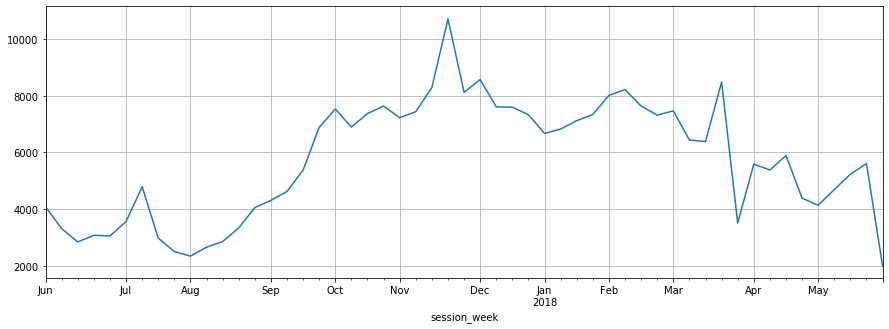

In [12]:
wau_total = visits.groupby(['session_week']).agg({'uid': 'nunique'}).mean()
print('В среднем в неделю сервис используют {} уникальных пользователей'.format(int(wau_total)))
visits.groupby(['session_week']).agg({'uid': 'nunique'}).plot(grid=True, figsize=(15, 5)).get_legend().remove()

**Выводы:** Как и на предыдущем графике, есть рост к концу года, в начале лета количество пользователей резко снижается, ориентировочно на 24 неделе.

Рассчитаю МAU и построю график изменения данных во времени:

В среднем в месяц сервис используют 23228 уникальных пользователей


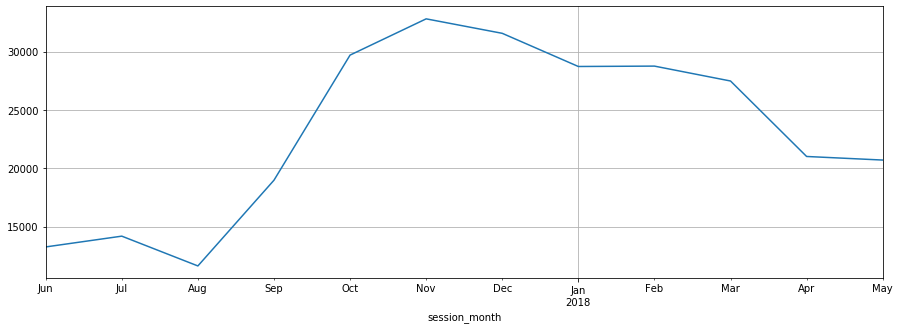

In [13]:
mau_total = visits.groupby(['session_month']).agg({'uid': 'nunique'}).mean()
print('В среднем в месяц сервис используют {} уникальных пользователей'.format(int(mau_total)))
visits.groupby(['session_month']).agg({'uid': 'nunique'}).plot(grid=True, figsize=(15, 5)).get_legend().remove()

**Выводы:** Можно предположить, что снижение количества пользователей связано в сезоном отпуском в летнее время, начиная с сентября начинается заметный рост, с пиком в конце года, а с февраля происходит спад. 

### Среднее количество посещений сайта в день

Рассчитаю количество посещений сайта в день и построю график:

In [14]:
session_nunique = visits.groupby(['session_date']).agg({'uid': 'nunique'}).mean()
session_count = visits.groupby(['session_date']).agg({'uid': 'count'}).mean()

Cреднее количество сессий на уникального пользователя в день 1.09


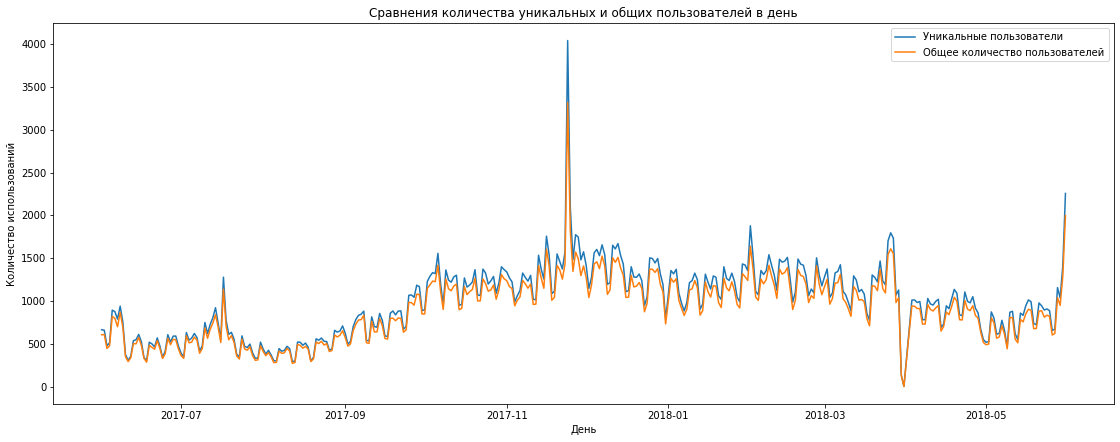

In [15]:
print('Cреднее количество сессий на уникального пользователя в день {:.3}'.format(float(session_count/session_nunique)))
plt.figure(figsize=(19, 7))
plt.plot(visits.groupby(['session_date']).agg({'uid': 'count'}));
plt.plot(visits.groupby(['session_date']).agg({'uid': 'nunique'}));
plt.title('Сравнения количества уникальных и общих пользователей в день')
plt.xlabel('День',fontsize=10)
plt.ylabel('Количество использований',fontsize=10)
plt.legend(['Уникальные пользователи', 'Общее количество пользователей'])
plt.show()

**Выводы:** Общее количество пользователей в день незначительно отличается от количества уникальных пользоватей сервиса.
График очень похож на предыдущие. Выводы по графику аналогичны.

### Сколько времени пользователи проводят на сайте

Рассчитаю длительность сессии на сайте:

In [16]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds / 60

Проверю, нет ли отрицательных значений после расчётов и сразу узнаю среднее.

In [17]:
visits['session_duration_sec'].describe()

count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: session_duration_sec, dtype: float64

Отрицательных значений нет, всё ок. 

Среднее значение около 11 минут. 
Проверю вид распределения на гистограмме:

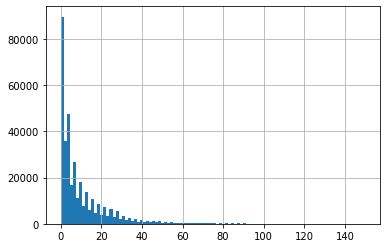

In [18]:
visits['session_duration_sec'].hist(bins=100,range = (0, 150))

Распределение неравномерно, среднее использовать нельзя, найду моду:

In [19]:
print(visits['session_duration_sec'].mode()) 

0    1.0
dtype: float64


**Выводы:** Как правило, пользователи находятся на сайте в течение одной минуты, при этом медианное значение составляет 5 минут, а среднее 10,7 минут.

### Расчёт Retention Rate

Рассчитаю Retention Rate

In [20]:
visits['activity_month'] = pd.to_datetime(visits['start_ts'].astype('datetime64[M]'))

In [21]:
first_activity = visits.groupby(['uid'])['activity_month'].min()
first_activity.name = 'first_activity_month'
visits = visits.join(first_activity, on='uid') 
first_activity = pd.to_datetime(first_activity.astype('datetime64[M]'))

In [22]:
visits['lifetime'] = (visits['activity_month'] - visits['first_activity_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

In [23]:
cohorts = visits.groupby(['first_activity_month','lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users = cohorts[cohorts['lifetime'] == 0][
    ['first_activity_month', 'uid']
]
initial_users = initial_users.rename(columns={'uid':'cohort_users'}) 

In [24]:
cohorts = cohorts.merge(initial_users,on='first_activity_month') 

In [25]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='lifetime',
    values='retention',
    aggfunc='sum',
) 

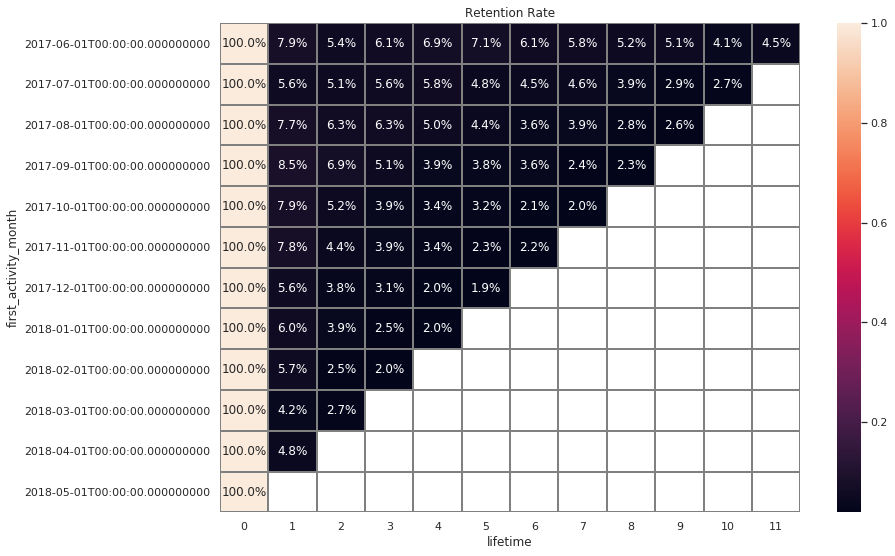

In [26]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

Рассчитаю средний Retention Rate на второй месяц «жизни» когорт:

In [27]:
cohorts[cohorts['lifetime'] == 1]['retention'].mean()*100

6.516659710392834

**Выводы:** Как правило возвращаются меньше 10% пользователей, в последующие периоды спад происходит значительно медленнее. 
А также есть отрицательная динамика по количеству возвращающихся пользователей начиная с октябрьской когорты 2017 года. 

Средний Retention Rate на второй месяц «жизни» когорт составляет 6,51%

### Среднее время с первого посещения сайта до момента совершения покупки

Рассчитаю среднее время с первого посещения сайта до момента совершения покупки в часах:

In [28]:
first_visit = visits.groupby('uid').agg({'start_ts':'min'}).reset_index()
first_order = orders.groupby('uid').agg({'buy_ts':'min'})
first_buy = first_visit.merge(first_order, on='uid') 
first_buy['time_before_purchase'] = (first_buy['buy_ts'] - first_buy['start_ts']).dt.seconds / 3600

Проверю, нет ли отрицательных значений после расчётов и среднее значение:

In [29]:
first_buy.describe()

,uid,time_before_purchase
count,3.652300e+04,36523.000000
mean,9.213152e+18,4.152745
std,5.324792e+18,7.162380
min,3.135781e+14,0.000000
25%,4.615081e+18,0.066667
50%,9.245161e+18,0.266667
75%,1.383709e+19,4.200000
max,1.844617e+19,23.983333


Отрицательных значений нет, построю гистограмму:

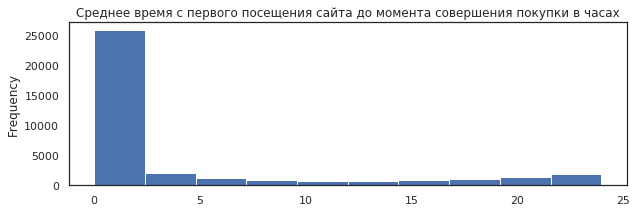

In [30]:
first_buy['time_before_purchase'].plot(kind = 'hist', bins = 10, figsize = (10, 3),
                                       title = ('Среднее время с первого посещения сайта до момента совершения покупки в часах'))

In [31]:
first_buy['time_before_purchase'].mode() * 60

0    1.0
dtype: float64

**Выводы:** Среднее время до совершения покупки 4 часа, но на гистограмме видно, что распределение неравномерное, поэтому рассчитала моду, она составляет 1 минуту. 

### Среднее количество покупок на одного покупателя за полгода

In [32]:
print('Среднее количество покупок на одного пользователя в 2017 и 2018 гг.')
(orders.groupby(['year'])['uid'].count() / orders.groupby(['year'])['uid'].nunique())

Среднее количество покупок на одного пользователя в 2017 и 2018 гг.


year
2017    1.326844
2018    1.315222
Name: uid, dtype: float64

Среднее количество покупок на одного пользователя в месяц за весь период: 1.222968553416106


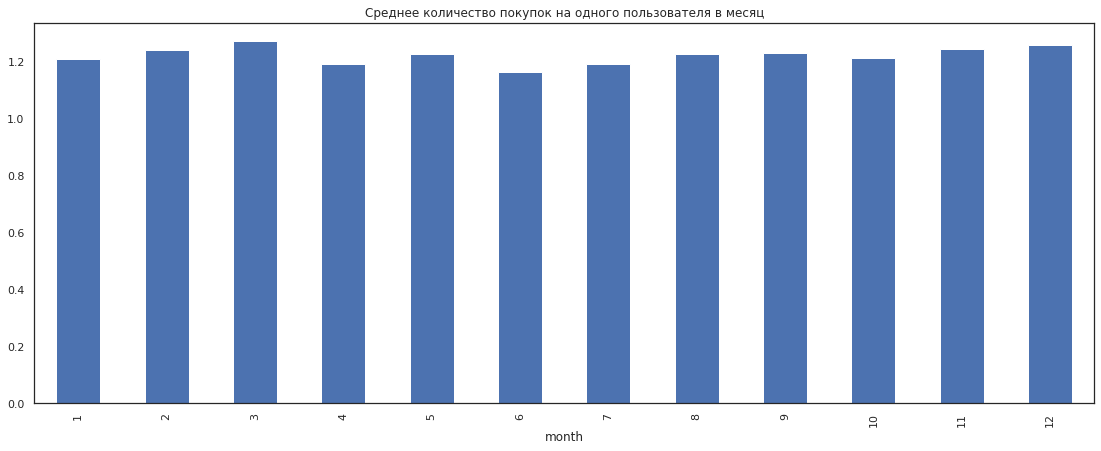

In [33]:
print('Среднее количество покупок на одного пользователя в месяц за весь период:',
     (orders.groupby(['month'])['uid'].count() / 
 orders.groupby(['month'])['uid'].nunique()).mean())

(orders.groupby(['month'])['uid'].count() / 
 orders.groupby(['month'])['uid'].nunique()).plot(kind='bar', figsize=(19, 7), title = "Среднее количество покупок на одного пользователя в месяц")

Среднее количество покупок на одного пользователя в неделю за весь период: 1.156124366245413


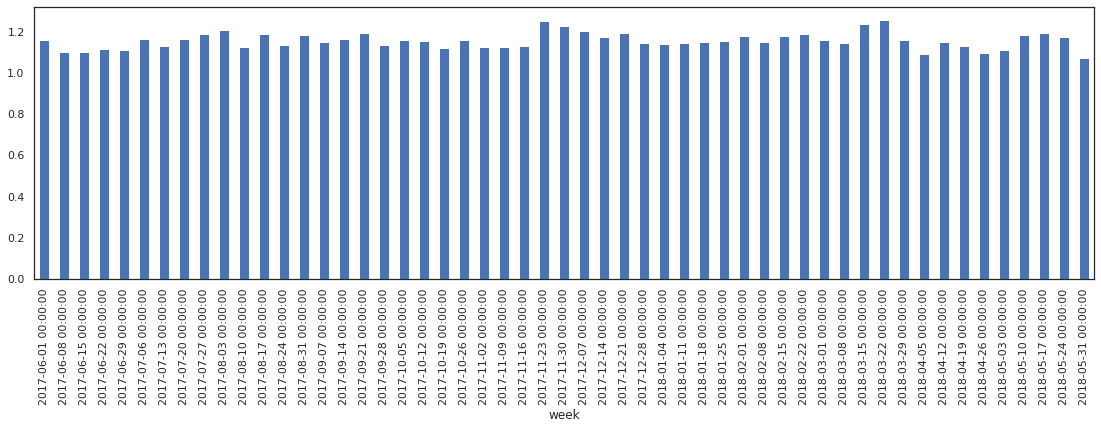

In [34]:
print('Среднее количество покупок на одного пользователя в неделю за весь период:',
     (orders.groupby(['week'])['uid'].count() / 
 orders.groupby(['week'])['uid'].nunique()).mean())

(orders.groupby(['week'])['uid'].count() / 
 orders.groupby(['week'])['uid'].nunique()).plot(kind='bar', figsize=(19, 5))

Рассчитаю среднее количество покупок на пользователя за полгода

In [35]:
orders_half_a_year = orders.query('month <= 5')
print('Среднее количество покупок на одного пользователя за полгода: {:.2f}'.format(
    (orders_half_a_year['uid'].count() / orders_half_a_year['uid'].nunique()).mean()))

Среднее количество покупок на одного пользователя за полгода: 1.32


**Выводы:** 
В среднем в год на одного покупателя приходится 1.31 покупка, то же среднее получила при расчёте данных за полгода.
Количество покупок на одного клиента в месяц ниже - 1.22, в неделю - 1.16.
Также, как и при расчёте данных о посещении клиентами ресурса, подъем виден с начала осени и до конца весны, летом происходит спад.

### Расчёт среднего чека с группировкой по времени покупки

Средний чек с группировкой по времени покупки: 
              revenue
year month          
2017 6      4.060106
     7      5.306589
     8      4.847139
     9      5.416448
     10     4.928280
     11     4.783518
     12     5.852139
2018 1      4.112927
     2      4.840095
     3      5.413930
     4      5.150645
     5      4.771279
     6      3.420000 
 Средний чек за весь период: 4.999646930477041


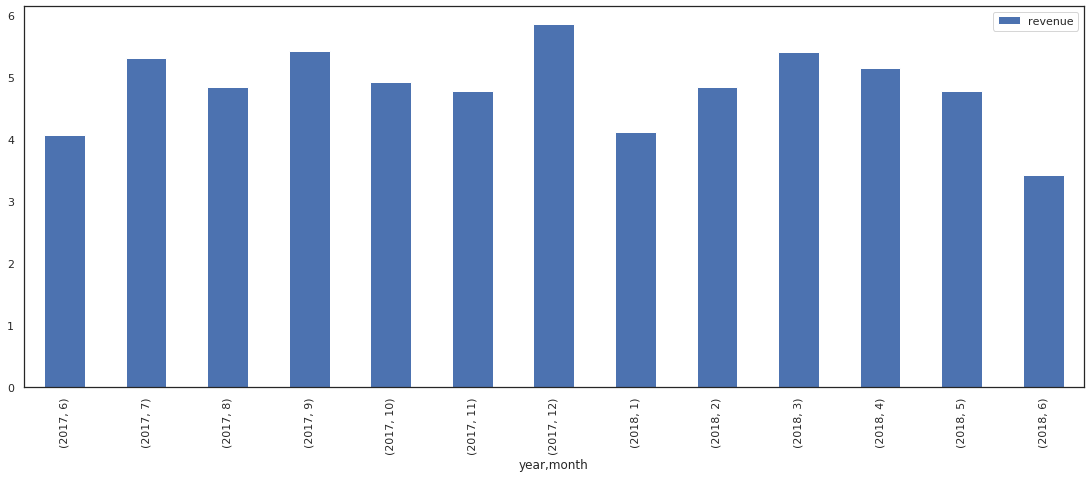

In [36]:
mean_check = orders.groupby(['year', 'month']).agg({'revenue' : 'mean'})
print('Средний чек с группировкой по времени покупки:',
      '\n',
      mean_check,
      '\n',
     'Средний чек за весь период:', orders['revenue'].mean())
mean_check.plot(kind='bar', figsize=(19, 7))

**Выводы:** Средний чек за весь период составляет 4.99 у.е. 
По графику видно, что самый высокий показатель в декабре 2017 года, в январе и июне 2018г. средний чек ниже остальных.


### Расчёт среднего LTV

Рассчитаю LTV, по условию маржинальность 100%

In [37]:
margin_rate = 1

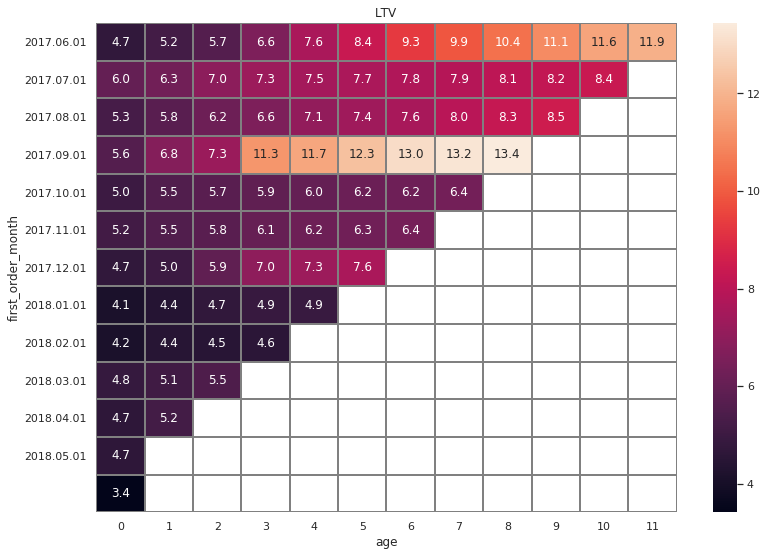

In [38]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = (first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index())
cohort_sizes.columns = ['first_order_month', 'n_buyers']

orders_new = pd.merge(orders,first_orders, on='uid')

cohorts = (orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index())

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['gp'] / report['n_buyers']

output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')

output = output.cumsum(axis=1).round(2)
output.fillna('')

plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(output, annot=True, fmt='.1f', linewidths=1, linecolor='gray', yticklabels=retention_pivot.index.strftime('%Y.%m.%d'))

**Вывод:** Максимальную выручку пользователи приносят в первый месяц, затем происходит спад, редко встречаются всплески.

Рассчитаю средний LTV по когортам за 6 месяцев, время "жизни" когорты более 6 месяцев.

In [39]:
report_avg_ltv = report.query('age >= 6')
print('Средний LTV за 6 месяцев составил {:.2f}'.format(report_avg_ltv['ltv'].mean()))

Средний LTV за 6 месяцев составил 0.32


### Общая сумма расходов на маркетинг. Распределение трат по источникам.

In [40]:
print('Общая сумма расходов на маркетинг:', costs['costs'].sum())

Общая сумма расходов на маркетинг: 329131.62


Рассчитаю распределение расходов на маркетинг по источникам:

   source_id      costs
2          3  141321.63
3          4   61073.60
4          5   51757.10
1          2   42806.04
0          1   20833.27
6         10    5822.49
5          9    5517.49


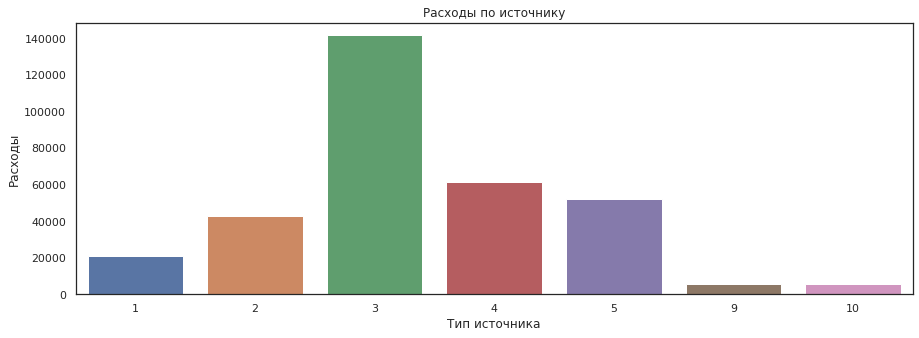

In [41]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index().sort_values(by = 'costs', ascending = False)
print(costs_by_source)
plt.figure(figsize = (15, 5))
ax = sns.barplot(x="source_id", y="costs", data=costs_by_source)
plt.title('Расходы по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Расходы')
plt.show()

Затем посчитаю расходы на маркетинг по месяцам:

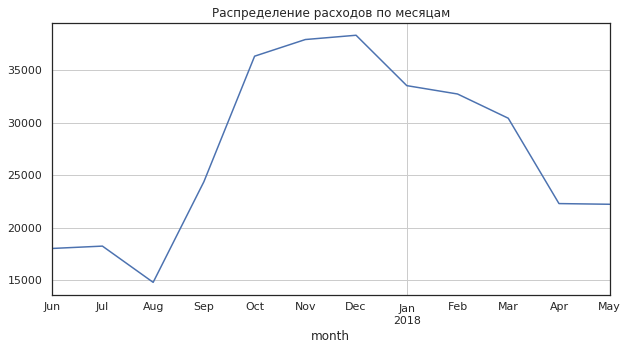

In [42]:
costs['month'] = pd.to_datetime(costs['dt'].astype('datetime64[M]'))
month_expenses_costs = costs.groupby('month')['costs'].sum()
month_expenses_costs.plot(grid=True, figsize=(10, 5), title = 'Распределение расходов по месяцам')

**Выводы:** Больше всего расходов на третий источник, расходы на остальные источники меньше в разы.

Самые большие расходы были в декабре, рост расходов наблюдается с сентября, в январе происходит спад.


### САС

Рассчитаю САС

In [43]:
visits_by_source  = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first', 
                                                                         'session_month': 'first'})
orders_by_source = visits_by_source.merge(orders, on = 'uid', how = 'inner')
orders_by_source = orders_by_source.groupby('source_id').agg({'uid':'nunique'}).reset_index().rename(columns={'uid':'users'})
costs_by_source = costs_by_source.merge(orders_by_source, on = 'source_id')
costs_by_source['cac'] = costs_by_source['costs'] / costs_by_source['users']
costs_by_source

,source_id,costs,users,cac
0,3,141321.63,10473,13.493901
1,4,61073.60,10296,5.931779
2,5,51757.10,6931,7.467479
3,2,42806.04,3506,12.209367
4,1,20833.27,2899,7.186364
5,10,5822.49,1329,4.381106
6,9,5517.49,1088,5.071222


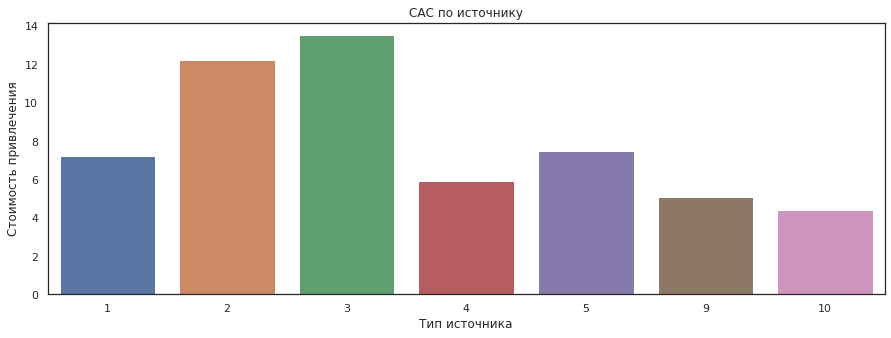

In [44]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x="source_id", y="cac", data=costs_by_source)
plt.title('CAC по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()

In [45]:
total_cac = costs_by_source['costs'].sum() / costs_by_source['users'].sum()
print('CAC для всего проекта {:.2f}'.format(total_cac))

CAC для всего проекта 9.01


**Выводы:**
Самые большие расходы на привлечение по источнику 3, этот же источник привлек больше остальных пользователей.
Затем по расходам источник 2, стоит отметить, что из этого источника привлечено в два раза меньше пользователей, чем с помощью источника 3, но есть и другие источники, расходы по которым меньше, а клиентов привлечено больше. 

### Расчёт ROMI

Рассчитаю ROMI

In [46]:
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'}).reset_index()
ltv = first_orders.merge(sources, on = 'uid')
ltv = ltv.merge(orders, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_order_month']) / np.timedelta64(1,'M')).round().astype(int)
report_ltv = ltv.groupby(['lifetime','source_id']).agg({'uid':'nunique', 'revenue': 'sum' }).reset_index()
report_ltv.columns = ['lifetime', 'source_id', 'n_buyers', 'revenue']

In [47]:
report_ltv_n_buyers = report_ltv.groupby('source_id').agg({'n_buyers':'sum'}).reset_index()
report_ltv_n_buyers.columns = ['source_id', 'n_buyers_sum']

In [48]:
report_ltv['gp'] = report_ltv ['revenue'] * margin_rate

In [49]:
report_ltv = report_ltv.merge(report_ltv_n_buyers, on='source_id')

In [50]:
report_ltv['ltv'] = report_ltv['gp'] / report_ltv['n_buyers_sum']
output_ltv = report_ltv.pivot_table(index = 'source_id', columns = 'lifetime', values='ltv', aggfunc='mean').round()
output_ltv

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,2.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
10,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [51]:
romi = report_ltv.merge(costs_by_source, on = 'source_id')
romi['romi'] = romi['ltv'] / romi['cac']
output_romi = romi.pivot_table(
    index='source_id', columns='lifetime', values='romi', aggfunc='mean'
) 
output_romi = output_romi.cumsum(axis=1).round(2)
output_romi.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.33,0.80,0.87,0.98,1.05,1.09,1.11,1.15,1.19,1.22,1.24,1.26,1.27
2,0.16,0.50,0.58,0.68,0.77,0.84,0.86,0.87,0.89,0.89,0.90,0.9,0.91
3,0.13,0.31,0.32,0.33,0.34,0.34,0.34,0.34,0.35,0.35,0.35,0.35,0.35
4,0.32,0.72,0.73,0.75,0.77,0.78,0.81,0.82,0.83,0.83,0.83,0.84,0.84
5,0.25,0.61,0.63,0.79,0.84,0.87,0.89,0.90,0.91,0.92,0.92,0.92,0.92
9,0.28,0.63,0.67,0.71,0.73,0.75,0.78,0.79,0.80,0.82,0.82,0.82,
10,0.32,0.69,0.70,0.70,0.71,0.71,0.71,0.72,0.72,0.72,0.72,,


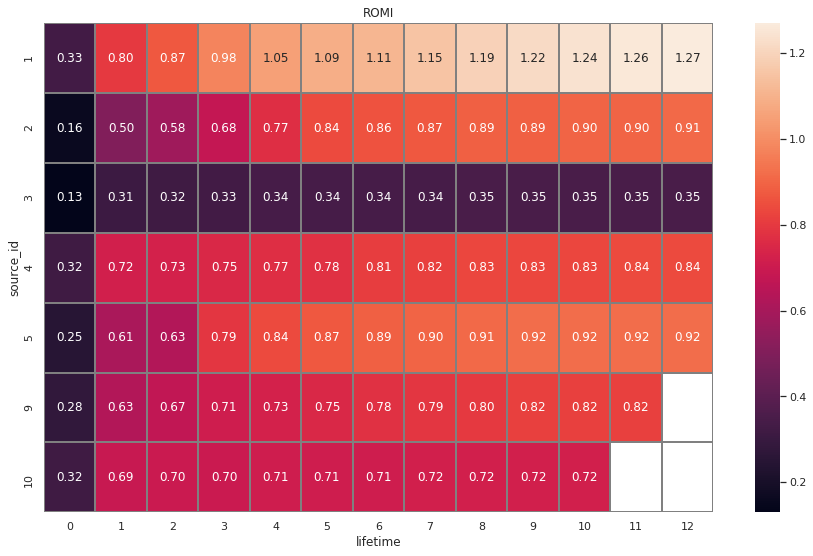

In [52]:
plt.figure(figsize=(15, 9))
plt.title('ROMI')
sns.heatmap(output_romi, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 

**Выводы:** Быстрее остальных окупились расходы по источнику 1, источник с самыми большими расходами 3 не окупился в течении всего время, такая же ситуация с источником 10. 
Остальные источники окупаются, но не так быстро, как у источника 1. 

## Выводы:

Невысокий показатель Retention Rate с первого месяца "жизни" каждой когорты. Необходимо работать над удержанием пользователей. 
Самая перспективная когорта 09-2017, на фоне прочих она выделилась в декабре.

Больше всего клиентов привлечено из источников 3 и 4, однако расходы по источнику 3 не окупаются, по источнику 4 расходы окупаются, но медленнее, чем по другим источникам.

Источники 1, 2 и 5 привлекают меньше клиентов, однако у них хорошая окупаемость. 